# Bertelsmann-Arvato Customer Segmentation
## Data Exploration 

The first step in working with any dataset is loading the data in and noting what information is included in the dataset. This is an important step in eventually working with any data, and knowing what kinds of features we have to work with.
In this notebook, we'll explore the data and observe the patterns in the data.

<ol>
    <li> Read data</li>
    <li> Study each attribute and it's characteristics:
        <ul>
        <li> Name</li>
        <li> Type</li>
        <li> Missing values</li>
        <li> Noisiness and type (stochastic, outliers, rounding errors, etc)</li>
        <li> Type of distribution</li>
        </ul>
    </li>
    <li> Identify target attributes</li>
    <li> Visualize the data</li>
    <li> Study correlation between attributes</li>
    <li> Identify promissing transformations</li>
</ol>

<hr>

In [1]:
import os

import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Read Data

In [23]:
def read_data(path='Data'):
    """Funtion to read data from given path, if it exists
    :param path: location of the data files
    :return: list of dataframes
    """
    
    if os.path.exists(path):
        print("Reading data from directory...")
    else:
        print("Path not found!")
        return -1
    
    # Datatypes of the columns containing numbers and 'X' or 'XX' values
    dtypes={'CAMEO_DEUG_2015': 'object',
            'CAMEO_INTL_2015': 'object'}
    
    # Reading csv files and removing any completely empty rows or columns 
    azdias = dd.read_csv(os.path.join(path, 'Udacity_AZDIAS_052018.csv'), sep=';', dtype=dtypes)
    customers = dd.read_csv(os.path.join(path, 'Udacity_CUSTOMERS_052018.csv'), sep=';', dtype=dtypes)
    train = dd.read_csv(os.path.join(path, 'Udacity_MAILOUT_052018_TRAIN.csv'), sep=';', low_memory=False)
    test = dd.read_csv(os.path.join(path, 'Udacity_MAILOUT_052018_TEST.csv'), sep=';', low_memory=False)
    
    attributes = pd.read_excel(os.path.join(path, 'DIAS Attributes - Values 2017.xlsx'), header=1).dropna(how='all', axis=1)
    information = pd.read_excel(os.path.join(path, 'DIAS Information Levels - Attributes 2017.xlsx'), header=1).dropna(how='all', axis=1)
    
    print("Completed!")
    return azdias, customers, train, test, attributes, information

In [24]:
azdias, customers, train, test, attributes, information = read_data()

Reading data from directory...
Completed!


Dask handles data in a “lazy” computational way, that's why it doesn't compute length of the datasets using shape() method

In [5]:
# number of rows and columns in dataset
AZDIAS_ROWS = len(azdias)
AZDIAS_COLS = len(azdias.columns)
CUSTOMERS_ROWS = len(customers)
CUSTOMERS_COLS = len(customers.columns)

print("AZDIAS\n number of columns: {}\t number of rows: {}".format(AZDIAS_COLS, AZDIAS_ROWS))
print("CUSTOMER\n number of columns: {}\t number of rows: {}".format(CUSTOMERS_COLS, CUSTOMERS_ROWS))

AZDIAS
 number of columns: 366	 number of rows: 891221
CUSTOMER
 number of columns: 369	 number of rows: 191652


In [6]:
# Finding common attributes bettween AZDIAS and Customers
comm_attr = list(set(customers.columns).intersection(azdias.columns))
diff_attr = list(set(customers.columns).difference(azdias.columns))

print("Number of attributes common between Customer and AZDIAS: {}".format(len(comm_attr)))
print("Number of attributes exclusive to Customer: {}".format(len(diff_attr)))
print("Attributes exclusive to CUSTOMERS: {}".format(diff_attr))

Number of attributes common between Customer and AZDIAS: 366
Number of attributes exclusive to Customer: 3
Attributes exclusive to CUSTOMERS: ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']


ONLINE_PURCHASE, PRODUCT_GROUP and CUSTOMER_GROUP are the attributes which are not in AZDIAS dataframe, but both datasets share rest of the features.

## Attributes

In [96]:
attributes.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


In [66]:
attributes.ffill(inplace=True) # Fill the NaN rows with description
attributes['Value'] = attributes['Value'].astype('str') # Changing datatype from object to str

attributes.head(25)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years


In [99]:
# unique attributes given in attributes dataframe (meta-data)
meta_attr = attributes['Attribute'].unique()

print("Total number of unique attributes given to us in meta data: ", len(meta_attr))
print("Total number of unique attributes in AZDIAS data: ", AZDIAS_COLS)
print("Total number of unique attributes in CUSTOMERS data: ", CUSTOMERS_COLS)

Total number of unique attributes given to us in meta data:  314
Total number of unique attributes in AZDIAS data:  366
Total number of unique attributes in CUSTOMERS data:  369


The number of attributes given is not same in the three datasets. This means some of the attributes were not important enough to be included in the meta data. Now, we'll look at how much of the attributes actually intersect with meta data attribute list. We've already compared AZDIAS and CUSTOMERS attribute list.

In [100]:
attr_common_all = set(comm_attr).intersection(meta_attr) # attributes common to all 3 talbes
attr_azdias_ex_meta = set(azdias.columns).difference(meta_attr) # attributes present in AZDIAS excluding Meta data attributes
attr_customers_ex_meta = set(customers.columns).difference(meta_attr)
attr_meta_ex_com = set(meta_attr).difference(comm_attr)

print("Len of attributes common to all the 3 tables: ", len(attr_common_all))
print("Len of attributes present in META excluding common (COSTOMER AND AZDIAS) data attributes: ", len(attr_meta_ex_com))
print("Len of attributes present in AZDIAS excluding Meta data attributes: ", len(attr_azdias_ex_meta))
print("Len of attributes present in CUSTOMERS excluding Meta data attributes: ", len(attr_customers_ex_meta))

Len of attributes common to all the 3 tables:  272
Len of attributes present in META excluding common features in COSTOMER AND AZDIAS data attributes:  42
Len of attributes present in AZDIAS excluding Meta data attributes:  94
Len of attributes present in CUSTOMERS excluding Meta data attributes:  97


## Missing data

### Identifying missing data
In this section, we'll identify the missing data which is represented using other values given in meta data other irregularities.

In [73]:
# numbers signifying unkown values in dataset
attributes.loc[attributes['Meaning'].str.contains('unknown'), 'Value'].unique()

array(['-1', '-1, 0', '0', '-1, 9'], dtype=object)

We can notice -1, 0 and 9 marked as 'unknown' values. This means other numerical values hold a significance, while these three values might be unknown. Now, we'll try to verify what 0, -1 and 9 individually signify in each attribute.

In [91]:
# Uniquie keywords that ZERO represent in datasets
print("Keywords for 0:")
print(attributes.loc[attributes['Value']=='0', 'Meaning'].unique())
print()
print("Keywords for -1:")
print(attributes.loc[attributes['Value']=='-1', 'Meaning'].unique())

Keywords for 0:
['no classification possible' 'unknown / no main age detectable'
 'no company in the building' 'unknown' 'no transactions known'
 'no transaction known' 'no Online-transactions within the last 12 months'
 "doesn't belong to the green avantgarde" 'classification not possible'
 'none' 'no 1-2 family homes' 'no 3-5 family homes' 'no 6-10 family homes'
 'no >10 family homes' 'external supplied hedonists '
 'no small office/home office' 'no score calculated']

Keywords for -1:
['unknown']


-1 always mean unkown values, while 0 may hold some value in some cases

In [95]:
# Attributes where 9 means unknown
attributes.loc[(attributes['Value'].str.contains('9')) & (attributes['Meaning'].str.contains('unknown')), 'Attribute'].unique()

array(['KBA05_ALTER1', 'KBA05_ALTER2', 'KBA05_ALTER3', 'KBA05_ALTER4',
       'KBA05_ANHANG', 'KBA05_AUTOQUOT', 'KBA05_CCM1', 'KBA05_CCM2',
       'KBA05_CCM3', 'KBA05_CCM4', 'KBA05_DIESEL', 'KBA05_FRAU',
       'KBA05_HERST1', 'KBA05_HERST2', 'KBA05_HERST3', 'KBA05_HERST4',
       'KBA05_HERST5', 'KBA05_HERSTTEMP', 'KBA05_KRSAQUOT',
       'KBA05_KRSHERST1', 'KBA05_KRSHERST2', 'KBA05_KRSHERST3',
       'KBA05_KRSKLEIN', 'KBA05_KRSOBER', 'KBA05_KRSVAN', 'KBA05_KRSZUL',
       'KBA05_KW1', 'KBA05_KW2', 'KBA05_KW3', 'KBA05_MAXAH',
       'KBA05_MAXBJ', 'KBA05_MAXHERST', 'KBA05_MAXSEG', 'KBA05_MAXVORB',
       'KBA05_MOD1', 'KBA05_MOD2', 'KBA05_MOD3', 'KBA05_MOD4',
       'KBA05_MOD8', 'KBA05_MODTEMP', 'KBA05_MOTOR', 'KBA05_MOTRAD',
       'KBA05_SEG1', 'KBA05_SEG10', 'KBA05_SEG2', 'KBA05_SEG3',
       'KBA05_SEG4', 'KBA05_SEG5', 'KBA05_SEG6', 'KBA05_SEG7',
       'KBA05_SEG8', 'KBA05_SEG9', 'KBA05_VORB0', 'KBA05_VORB1',
       'KBA05_VORB2', 'KBA05_ZUL1', 'KBA05_ZUL2', 'KBA05_ZUL3',
    

There are 75 unique attributes where 9 signify 'unknown' value. These attributes mainly begin with 'KBA05' and 'SEMIO', along with 2 other attributes named 'RELAT_AB' and 'ZABEOTYP'.

While reading the data we shuned a warning by setting data type of few columns to 'object' type, now, we'll look into those columns.

In [110]:
azdias.loc[:10,azdias.dtypes == 'object'].compute()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W
5,8C,8,54,D19_ENERGIE,1992-02-12 00:00:00,W
6,4A,4,22,D19_UNBEKANNT,1992-02-12 00:00:00,W
7,2D,2,14,D19_UNBEKANNT,1992-02-10 00:00:00,W
8,1A,1,13,NaN,1992-02-10 00:00:00,W
9,1E,1,15,D19_KOSMETIK,1992-02-10 00:00:00,W


In [112]:
azdias['CAMEO_DEUG_2015'].unique().compute()

0     NaN
1       8
2       4
3       2
4       6
5       1
6       9
7       5
8       7
9       3
10      X
Name: CAMEO_DEUG_2015, dtype: object

In [115]:
azdias['CAMEO_INTL_2015'].unique().compute()

0     NaN
1      51
2      24
3      12
4      43
5      54
6      22
7      14
8      13
9      15
10     33
11     41
12     34
13     55
14     25
15     23
16     31
17     52
18     35
19     45
20     44
21     32
22     XX
Name: CAMEO_INTL_2015, dtype: object

Notice the presence of 'X' and 'XX' in columns. We'll replace this with NaN and also convert the datatype of 'EINGEFUEGT_AM' attribute to datetime type.

### Marking missing values
In previous section we identified the keywords or values which were being used to mark unknown data. In this section we'll replace those keywords with NaN, to easily proceed further.

In [125]:
# Replacing X and XX with NaN
azdias = azdias.mask((azdias == 'X') | (azdias == 'XX'), -1)
customers = customers.mask((customers == 'X') | (customers == 'XX'), -1)

# customers[(customers == 'X') | (customers == 'XX')] = '-1'

C:\Users\Arijit Aakriti\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [121]:
azdias

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [ ]:
def identifyNaN(df, meta_df):
    """ Function to replace the 
    """
    # Replacing X and XX with NaN


In [ ]:
# Replace -1 in datasets with NaN values


In [39]:
# Find attributes with more than 25% of missing values in AZDIAS dataset
missing_pct_azdias = ((azdias.isna().sum() / AZDIAS_ROWS) * 100)
missing_pct_azdias = missing_pct_azdias.compute()

print(missing_pct_azdias[missing_pct_azdias > 25])

ALTER_KIND1                    90.904837
ALTER_KIND2                    96.690047
ALTER_KIND3                    99.307691
ALTER_KIND4                    99.864792
ALTERSKATEGORIE_FEIN           29.504130
D19_BANKEN_ONLINE_QUOTE_12     28.849522
D19_GESAMT_ONLINE_QUOTE_12     28.849522
D19_KONSUMTYP                  28.849522
D19_LETZTER_KAUF_BRANCHE       28.849522
D19_LOTTO                      28.849522
D19_SOZIALES                   28.849522
D19_TELKO_ONLINE_QUOTE_12      28.849522
D19_VERSAND_ONLINE_QUOTE_12    28.849522
D19_VERSI_ONLINE_QUOTE_12      28.849522
EXTSEL992                      73.399639
KK_KUNDENTYP                   65.596749
dtype: float64


It seems only few attributes have more than 25% of missing values and only 6 attributes have missing percentage of more than 30%. So, we'll check which attributes are having missing percentage of more than 30% in CUSTOMERS dataframe.

In [40]:
# Checking missing values in Customers 
missing_pct_customers = ((customers.isna().sum() / customers.index.size) * 100)
missing_pct_customers = missing_pct_customers.compute()
missing_30pct_customers = missing_pct_customers[missing_pct_customers > 30]

print(missing_30pct_customers)

ALTER_KIND1     93.860748
ALTER_KIND2     97.338927
ALTER_KIND3     99.334732
ALTER_KIND4     99.876860
EXTSEL992       44.498883
KK_KUNDENTYP    58.406382
dtype: float64


In [41]:
missing_30pct_azdias = missing_pct_azdias[missing_pct_azdias > 30]

print(missing_30pct_azdias)

ALTER_KIND1     90.904837
ALTER_KIND2     96.690047
ALTER_KIND3     99.307691
ALTER_KIND4     99.864792
EXTSEL992       73.399639
KK_KUNDENTYP    65.596749
dtype: float64


We can notice same columns having missing values of more than 30% in both of the datasets. So, we'll now remove this columns.
(See: https://discuss.analyticsvidhya.com/t/what-should-be-the-allowed-percentage-of-missing-values/2456/5)

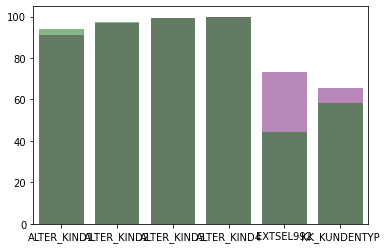

In [106]:
# plt.figure(figsize=(10, 5))
# Plot 1
sns.barplot(x=missing_30pct_azdias.index, y=missing_30pct_azdias, alpha=0.5, color='purple')
sns.barplot(x=missing_30pct_customers.index, y=missing_30pct_customers, alpha=0.5, color='green')

In [112]:
# List of columns/attributes to be deleted from the datasets
DEL_COLS = missing_30pct_azdias.index.values

azdias_clean = azdias.drop(DEL_COLS, axis=1).compute()
customers_clean = customers.drop(DEL_COLS, axis=1).compute()

In [114]:
print("Number of attributes in AZDIAS after deleting missing values:", azdias_clean.columns.size)
print("Number of attributes in CUSTOMERS after deleting missing values:", customers_clean.columns.size)

Number of attributes in AZDIAS after deleting missing values: 360
Number of attributes in CUSTOMERS after deleting missing values: 363


Now, we'll analyze the attribute exclusive to CUSTOMERS dataset.

In [127]:
diff_attr = list(diff_attr)
customers_clean.loc[:, diff_attr].dtypes

ONLINE_PURCHASE     int64
PRODUCT_GROUP      object
CUSTOMER_GROUP     object
dtype: object

In [134]:
customers_clean.loc[:,'ONLINE_PURCHASE'].describe()

count    191652.000000
mean          0.090247
std           0.286536
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: ONLINE_PURCHASE, dtype: float64

(array([174356.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  17296.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

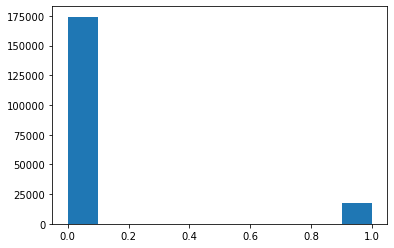

In [136]:
plt.hist(customers_clean.loc[:, 'ONLINE_PURCHASE'])

In [138]:
# % of customers who bought products online
online_pct = (sum(customers_clean.loc[:, 'ONLINE_PURCHASE']) / customers_clean.index.size) * 100

print("Percentage of customers who made purchase online: ", online_pct)

Percentage of customers who made purchase online:  9.02469058501868


(array([100860.,      0.,      0.,      0.,      0.,  47382.,      0.,
             0.,      0.,  43410.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

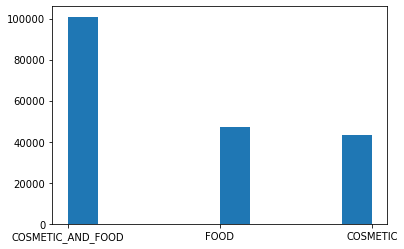

In [139]:
plt.hist(customers_clean.loc[:, 'PRODUCT_GROUP'])

In [142]:
# Percentage of 
customers_clean.loc[:, 'PRODUCT_GROUP'].value_counts() * 100 / customers_clean.index.size

COSMETIC_AND_FOOD    52.626636
FOOD                 24.722935
COSMETIC             22.650429
Name: PRODUCT_GROUP, dtype: float64

(array([132238.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  59414.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

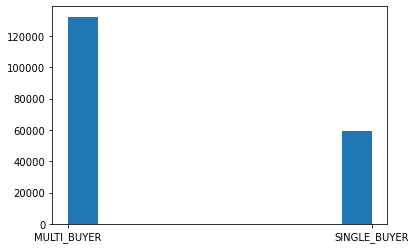

In [143]:
plt.hist(customers_clean.loc[:, 'CUSTOMER_GROUP'])

In [144]:
customers_clean.loc[:, 'CUSTOMER_GROUP'].value_counts() * 100 / customers_clean.index.size

MULTI_BUYER     68.999019
SINGLE_BUYER    31.000981
Name: CUSTOMER_GROUP, dtype: float64

### Other missing data